# **Clasificación y Detección de Calidad en Frutas y Verduras a través de Redes Neuronales Convolucionales**
### Ximena Elgart - Leonel Leguizamón


---



# Introducción

Este proyecto se enmarca en la materia 'Neuroscience of Learning Machines' y tiene como objetivo aplicar los conceptos aprendidos sobre redes neuronales y su capacidad para reconocer y clasificar imágenes.

Con este fin, se desarrolló una red neuronal convolucional (CNN) capaz de clasificar frutas y verduras y determinar si están frescas o podridas. Dado que estamos prediciendo dos tipos diferentes de clases (nombre y frescura), la red neuronal debe tener múltiples salidas.

El reconocimiento de alimentos frescos es una aplicación relevante en la industria alimentaria, donde puede ser útil para su implementación en heladeras inteligentes, permitiendo advertir al usuario sobre el estado de las frutas y verduras. Además, se podría implementar en supermercados para mejorar la gestión de productos y reducir el desperdicio.


# Recolección de Datos

Para este proyecto, se utilizó el conjunto de datos [Fresh and Stale Classification](https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification) disponible en Kaggle.

Este conjunto de datos contiene imágenes de frutas como manzanas, bananas, naranjas, y de verduras como pepinos, papas y tomates, tanto en buen como en mal estado, las cuales se utilizarán para entrenar y evaluar la red neuronal. Además, es necesario aclarar que el dataset contiene carpetas de Train y de Test, lo que permite tener los datos divididos para entrenamiento y para prueba.


# Aclaraciones
Durante la elaboración del proyecto y las diferentes pruebas que hemos realizado, notamos que los porcentajes de precisión arrojados por la red neuronal varían entre cada ejecución, lo cual puede comprometer el análisis realizado durante el desarrollo respecto a lo que puede arrojar la red durante la evaluación del proyecto. En tanto, realizaremos el análisis utilizando rangos cuando sea posible, y en los casos donde utilicemos valores exactos, será necesario tener en cuenta esta aclaración.

Con esto en mente, continuemos.


# Importación de Librerías

In [1]:
# Librerías para Manipulación de Archivos
import os
import shutil
import json

# Librerías para Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.preprocessing import image

# Librerías para Manejo de Datos
import numpy as np
import pandas as pd

# Librerías para Visualización
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Carga de Datos

Es necesario conectar con la cuenta de Google con la que hemos compartido la carpeta "Neuroscience", dado que será necesario más adelante

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Crear el directorio .kaggle si no existe
os.makedirs('/root/.kaggle', exist_ok=True)

# Contenido del archivo JSON con las credenciales de Kaggle
kaggle_json_content = '{"username":"leonelleguizamon","key":"6b9c594a6b79c73c9f8b585650415390"}'

# Guardar las credenciales en el archivo kaggle.json usando echo
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(kaggle_json_content)

# Cambiar los permisos del archivo
os.system('chmod 600 /root/.kaggle/kaggle.json')

# Instalar la biblioteca Kaggle
!pip install kaggle

# Descarga de Dataset
!kaggle datasets download -d swoyam2609/fresh-and-stale-classification

# Extraemos lo descargado
!unzip fresh-and-stale-classification.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_5372.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_54.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6186.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6285.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6551.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6565.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_6985.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_7173.jpg  
  inflating: dataset/Train/rottencapsicum/WhatsApp Image 2020-11-07 at 11.43.17 PM.jpg_0_7306.jpg  
  inflating: dataset/Train/rottencapsicum

A continuación, se cargan las imágenes obtenidas en un dataframe que distinga en archivos, nombre de fruta y frescura.

Es importante aclarar que los nombres de las carpetas que contienen las imágenes tienen el formato `<estado><nombre_fruta>`, por lo que en el caso de una manzana podrida, tendra el nombre `rottenapples`. Es por ello que, al agregar las frutas a su arreglo correspondiente, se realiza un slice para **quitar el estado y quedarnos solamente con el nombre de la fruta.**

In [4]:
TRAIN_PATH = "/content/dataset/Train"
TEST_PATH = "/content/dataset/Test"

def load_data(PATH):
    filenames, fruit, fresh = [], [], []

    for file in os.listdir(PATH): # Por cada carpeta en Train / Test
        for img in os.listdir(os.path.join(PATH, file)): # Por cada imagen en Train / Test
            fresh.append(1 if file.startswith('fresh') else 0) # 1 para frutas frescas, 0 para podridas
            fruit.append(file[5:] if file.startswith('fresh') else file[6:]) # Obtenemos la clase
            filenames.append(os.path.join(PATH, file, img))

    df = pd.DataFrame({
        'filename': filenames,
        'fruit': fruit,
        'fresh': fresh
    })

    return df

# Cargar archivos; sample(frac=1) garantiza aleatoriedad en el orden de las imagenes del df
df_train = load_data(TRAIN_PATH).sample(frac=1)
df_test = load_data(TEST_PATH).sample(frac=1)

# Analisis de Datos

Luego de realizar la carga de los archivos, podemos visualizar los dataframes para ver las frutas y verduras que tiene cada uno.

In [5]:
print("\nDatos en train: ", df_train.fruit.unique())
print("\nDatos en test: ", df_test.fruit.unique())


Datos en train:  ['tomato' 'apples' 'cucumber' 'banana' 'oranges' 'bittergroud' 'okra'
 'potato' 'capsicum']

Datos en test:  ['apples' 'cucumber' 'tamto' 'oranges' 'banana' 'patato' 'okra']


Como se puede observar, en test hay nombres de frutas mal escritos, como 'tamto' y 'patato', además de que hay frutas que se encuentran en el conjunto de datos de train, pero no de test, por lo que no servirán para ser analizados.

Ademas de esto, eliminamos los datos sobre 'Okra' debido a que desconocemos que verdura es y hay pocas muestras del mismo.

In [6]:
# Corregir diferencias de nombres entre Train y Test
def edit_names(df_train, df_test):
    # Eliminar filas con frutas específicas en df_train
    df_train.drop(df_train[df_train['fruit'].isin(['okra', 'capsicum', 'bittergroud'])].index, inplace=True)

    # Eliminar filas con 'okra' en df_test
    df_test.drop(df_test[df_test['fruit'] == 'okra'].index, inplace=True)

    # Reemplazar valores incorrectos en df_test
    df_test['fruit'] = df_test['fruit'].replace({'tamto': 'tomato', 'patato': 'potato'})

    return df_train, df_test

df_train, df_test = edit_names(df_train, df_test)
# Visualizar dataframes para ver frutas y verduras existentes, ordenadas
print("\nDatos en train: ", sorted(df_train.fruit.unique()))
print("\nDatos en test: ", sorted(df_test.fruit.unique()))


Datos en train:  ['apples', 'banana', 'cucumber', 'oranges', 'potato', 'tomato']

Datos en test:  ['apples', 'banana', 'cucumber', 'oranges', 'potato', 'tomato']


Para poder tener un mejor entendimiento de los datos brindados por el dataset, se realizó un gráfico de barras el cual indica la cantidad de frutas frescas y podridas presentes tanto en Train como en Test.

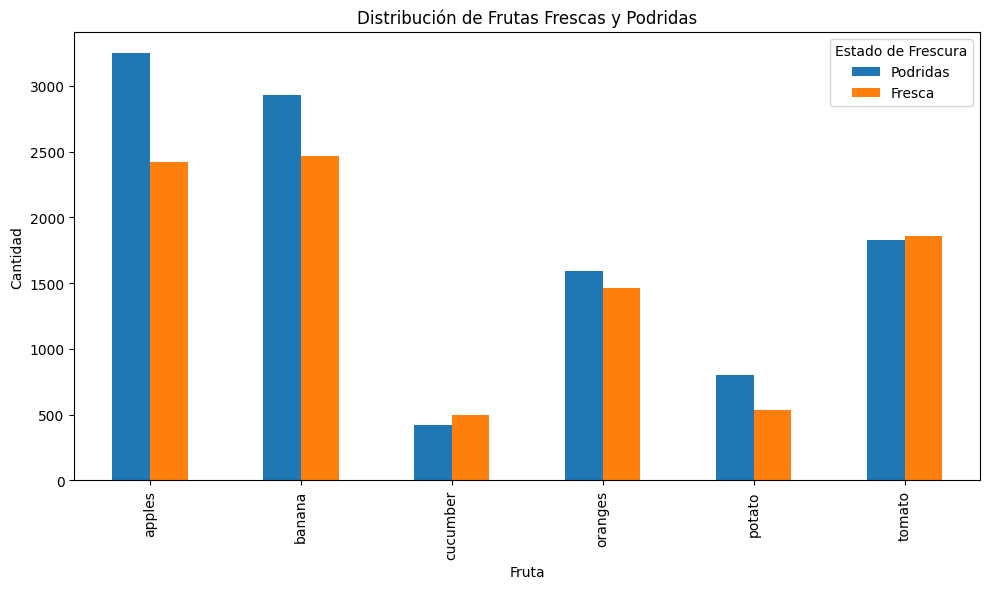

In [7]:
def plot_freshness_distribution(df):
    # Agrupar por fruta y estado de frescura y contar las ocurrencias
    fruit_fresh_count = df.groupby(['fruit', 'fresh']).size().unstack(fill_value=0)

    # Crear el gráfico de barras
    ax = fruit_fresh_count.plot(kind='bar', figsize=(10, 6))

    # Etiquetas y título
    ax.set_xlabel('Fruta')
    ax.set_ylabel('Cantidad')
    ax.set_title('Distribución de Frutas Frescas y Podridas')
    ax.legend(['Podridas', 'Fresca'], title='Estado de Frescura')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

plot_freshness_distribution(df_train)

Observando el grafico de barras, podemos notar una desproporción entre la cantidad de manzanas y bananas respecto al resto de frutas y verduras. Esto podria llevar a un sesgo en la red neuronal, donde probablemente afecte en la determinación de la clasificación.

Para esto, se decidió limitar la cantidad de imágenes a 1000 y luego aplicar una técnica de data augmentation a todo el nuevo dataset. De esta manera tendremos cantidades similares de cada imagen, y podremos enriquecer nuestro dataset de entrenamiento.

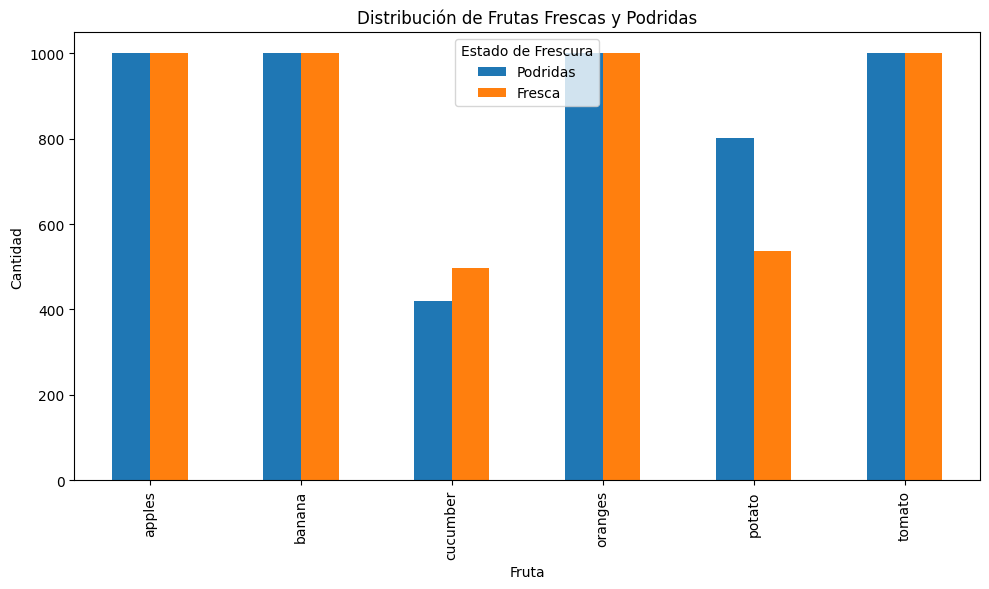

In [8]:
# Limitar la cantidad de imágenes a 1000 por cada combinación de fruta y frescura, aleatoriamente
def limit_images(df, limit):
    return df.groupby(['fruit', 'fresh']).apply(lambda x: x.sample(min(len(x), limit))).reset_index(drop=True)

df_train = limit_images(df_train, limit=1000)
df_test = limit_images(df_test, limit=1000)

plot_freshness_distribution(df_train)

# Configuración Modelo v1

## Crear Datasets a partir de los Dataframes

Una vez que tenemos los Dataframes con los datos en limpio, podemos crear los conjuntos de datos (datasets) a partir de ellos para poder trabajar con TensorFlow y construir la red neuronal.

En primer lugar, definimos un tamaño de imagen que se utilizará para redimensionar las mismas a un tamaño uniforme. Reducir el tamaño de las imágenes ayuda a mejorar la velocidad del entrenamiento y reduce la cantidad de memoria necesaria para procesarlas.

Luego de realizar varias pruebas con distintos tamaños, finalmente se eligió 96 por ser el número más grande soportado por el entorno de Colab sin agotar la memoria RAM. Con mejores recursos, se podría haber elegido un tamaño de 128 o superior, sin afectar el tamaño del batch.

In [9]:
IMG_SIZE = 96

# Carga y preprocesado de imagenes
def load_and_preprocess_image(filename, label_fruit, label_fresh):
    image = tf.io.read_file(filename) # Leer imagenes
    image = tf.image.decode_jpeg(image, channels=3)  # Channels = 3 para imagenes en color. Es necesario puesto que influye en la efectividad del modelo.
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE]) # Redimensionamos
    image = tf.cast(image, tf.float32) / 255.0  # Normalizamos RGB a valores [0, 1]
    return image, (label_fruit, label_fresh)

# Creamos los datasets a partir de los dataframes con los filepaths de las imagenes
def create_dataset(df):
    filenames = df['filename'].values
    labels_fruit = df['fruit'].astype('category').cat.codes.values # Convierte las categorias (apples bananas, etc) a enteros categoricos, P.E: 0: apples, 1: banana
    labels_fresh = df['fresh'].values

    # Crear el dataset a partir de los nombres de archivos y etiquetas
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels_fruit, labels_fresh))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset


Después de crear los Datasets, es necesario dividir los datos que serán utilizados para entrenamiento y para validación. Para esto, nos quedamos con el 90% de los datos para entrenamiento, y lo restante para validación.

In [10]:
def create_validation_dataset(ds, df_length):
    # Calcular el tamaño de los datasets de train y validation
    train_size = int(0.90 * df_length)
    val_size = df_length - train_size

    # Dividir el dataset en train y validation
    ds_train_full = ds
    ds_train = ds_train_full.take(train_size)
    ds_val = ds_train_full.skip(train_size)

    return ds_val, ds_train

Finalmente, se configuran los datasets `ds_train`, `ds_val` y `ds_test` para el entrenamiento y evaluación del modelo. Los datasets se agrupan en lotes de tamaño `BATCH_SIZE`, se prefetchean para optimizar el rendimiento utilizando `tf.data.experimental.AUTOTUNE` (permitiendo que TensorFlow decida automáticamente el número óptimo de lotes), y se mezclan aleatoriamente (`shuffle`) para evitar que el modelo aprenda el orden de los ejemplos. Esto prepara los datos de manera eficiente para el entrenamiento de redes neuronales utilizando TensorFlow.

Cabe aclarar que a mayor `batch_size`, se procesan más muestras de datos simultáneamente en cada iteración de entrenamiento (lo cual fue una variable a tener en cuenta para no agotar la memoria RAM del entorno durante el entrenamiento), mientras que a mayor `buffer_size` en la operación de shuffle, más elementos del dataset se mezclan al azar antes de dividirlos en lotes.

In [11]:
# Crear y configurar los datasets
def get_final_datasets(df_train, df_test, BATCH_SIZE):
    # Crear el dataset, funcion definida anteriormente
    ds_train = create_dataset(df_train)
    ds_test = create_dataset(df_test)
    ds_val, ds_train = create_validation_dataset(ds_train, len(df_train))

    # Verificar el tamaño de los datasets
    print("Longitud de ds_train luego de separar:", len(ds_train))
    print("Longitud de ds_val luego de separar:", len(ds_val))
    print("Longitud de ds_test:", len(ds_test))

    # Configurar los datasets
    ds_train = ds_train.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).shuffle(buffer_size=1000)
    ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    return ds_train, ds_val, ds_test

ds_train, ds_val, ds_test = get_final_datasets(df_train, df_test, BATCH_SIZE=32)



Longitud de ds_train luego de separar: 9229
Longitud de ds_val luego de separar: 1026
Longitud de ds_test: 6144


## Definición de arquitectura de CNN

Ya con los Datasets de entrenamiento, validación y prueba armados, se puede crear el modelo de red neuronal para clasificar imágenes de frutas y verduras y determinar si están frescas o podridas.

Primero es necesario definir los parámetros del modelo:
*   `input_shape` define el tamaño de las imágenes de entrada, donde `IMG_SIZE` es el tamaño predefinido para las imágenes y *3* representa los canales RGB de las imágenes a color.
*   `num_fruits` calcula el número único de clases de frutas en el conjunto de datos de entrenamiento `df_train`. Esto se utiliza más adelante para determinar la cantidad de salidas en la capa de salida de frutas.



In [12]:
# Parámetros del modelo
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_fruits = df_train['fruit'].nunique()

Posteriormente, se define el modelo base que incluye las capas de data augmentation, seguidas de capas convolucionales y de pooling.

Las capas de data augmentation aplican transformaciones aleatorias a las imágenes durante el entrenamiento, ayudando a aumentar la diversidad del conjunto de datos y mejorando la capacidad del modelo para generalizar.

Por otro lado, las imágenes pasan por capas sucesivas de filtros (convolución) y pooling (compactación). Estos feature maps se aplanan (flattening) y son la entrada de una red densa tradicional que clasifica.

In [13]:
# Layers para Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
])

model = tf.keras.Sequential([
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
])

# Creacion de una capa de entrada con las dimensiones correspondientes con las imagenes
inputs = layers.Input(shape=input_shape)

Dado que nuestro modelo posee dos salidas (Fruit y Fresh), es necesario utilizar la API funcional de Keras para especificarle al modelo las salidas deseadas. Esto ultimo no es posible utilizando Sequential, por lo que se hace a través de la primera línea de código que se encuentra a continuación.

La salida asociada a Fresh (quien indica si una fruta esta podrida o no) es una capa densa de 1 neurona con activacion Sigmoid. La función sigmoide toma cualquier valor real de entrada y lo convierte a un rango entre 0 y 1, lo cual es adecuado para este problema de clasificación binaria ya que puede interpretarse como una probabilidad.

Por otro lado, la salida asociada a Fruit, se utiliza como clasificador probabilistico de la fruta dada como entrada, donde cada valor está en el rango [0, 1], y la suma de todas las probabilidades es igual a 1. Esto es útil en nuestro problema puesto que al tener varios tipos de frutas, es una clasificación multiclase, donde cada clase tiene una probabilidad asociada.

In [14]:
x = model(inputs)

fresh_output = layers.Dense(1, activation='sigmoid', name='fresh_output')(x)

fruit_output = layers.Dense(num_fruits, activation='softmax', name='fruit_output')(x)

Por último, se combinan las capas de entrada y salida para formar el modelo completo y se configura el modelo para el entrenamiento especificando el optimizador, las funciones de pérdida y las métricas para cada salida del modelo (fruit_output y fresh_output). Se utiliza `sparse_categorical_crossentropy` para la salida de frutas multiclase y `binary_crossentropy` para la salida de frescura binaria.

In [15]:
# Asociamos las capas de entrada y salida al modelo
model = tf.keras.Model(inputs=inputs, outputs=[fruit_output, fresh_output])

# Resumen
model.summary()

model.compile(
    optimizer='adam',
    loss={
      'fruit_output': 'sparse_categorical_crossentropy',
      'fresh_output': 'binary_crossentropy'
      },
    metrics={
      'fruit_output': ['sparse_categorical_accuracy'],
      'fresh_output': ['accuracy']
      }
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 30976)                19392     ['input_1[0][0]']             
                                                                                                  
 fruit_output (Dense)        (None, 6)                    185862    ['sequential_1[0][0]']        
                                                                                                  
 fresh_output (Dense)        (None, 1)                    30977     ['sequential_1[0][0]']        
                                                                                              

## Entrenamiento del Modelo

Finalmente, el modelo ya puede ser entrenado utilizando los datos proporcionados por `ds_train`.

Las `epochs` indican las iteraciones completas sobre el conjunto de datos de entrenamiento, `verbose` se utiliza para mostrar una barra de progreso durante el entrenamiento, y `validation_data` que es un conjunto de datos de validación con imágenes de frutas y verduras que la red neuronal no ha utilizado como parte del entrenamiento pero serán usadas para comprobar qué tan bien o qué tan mal se ha entrenado el modelo en cada epoch.

Como último paso, se evalua el rendimiento del modelo en el conjunto de prueba después de que el entrenamiento haya finalizado.

In [16]:
# Entrenar el modelo
history_v1 = model.fit(
    ds_train,
    epochs=5,
    verbose=1,
    validation_data=ds_val,
)

# Evaluar el modelo en el conjunto de test
loss, fruit_loss, fresh_loss, fruit_acc, fresh_acc = model.evaluate(ds_test)

evaluate_v1 = {
    'loss': loss,
    'fruit_loss': fruit_loss,
    'fresh_loss': fresh_loss,
    'fruit_acc': fruit_acc,
    'fresh_acc': fresh_acc
}

print(f"Fruit Accuracy: {evaluate_v1['fruit_acc']}, Fresh Accuracy: {evaluate_v1['fresh_acc']}")
tf.keras.backend.clear_session()

Epoch 1/5
289/289 [==============================] - 73s 90ms/step - loss: 2.5155 - fruit_output_loss: 1.8020 - fresh_output_loss: 0.7135 - fruit_output_sparse_categorical_accuracy: 0.2649 - fresh_output_accuracy: 0.5452 - val_loss: 2.8790 - val_fruit_output_loss: 1.9909 - val_fresh_output_loss: 0.8881 - val_fruit_output_sparse_categorical_accuracy: 0.0000e+00 - val_fresh_output_accuracy: 0.0731
Epoch 2/5
289/289 [==============================] - 49s 97ms/step - loss: 1.9955 - fruit_output_loss: 1.4073 - fresh_output_loss: 0.5881 - fruit_output_sparse_categorical_accuracy: 0.3929 - fresh_output_accuracy: 0.7079 - val_loss: 2.8746 - val_fruit_output_loss: 1.6749 - val_fresh_output_loss: 1.1997 - val_fruit_output_sparse_categorical_accuracy: 0.4717 - val_fresh_output_accuracy: 0.0429
Epoch 3/5
289/289 [==============================] - 50s 96ms/step - loss: 1.7570 - fruit_output_loss: 1.2206 - fresh_output_loss: 0.5363 - fruit_output_sparse_categorical_accuracy: 0.5168 - fresh_output_ac

## Análisis de Resultados - Modelo v1

Luego de evaluar el rendimiento del modelo, podemos ver que la precisión de predicción del tipo de fruta varía entre el 70 y 85%, mientras que para la frescura, varía entre un 65 y 80%. No podemos poner valores exactos puesto que en cada entrenamiento los porcentajes fueron variando en el rango especificado.

De igual manera, estos resultados no nos dejan conformes, por lo que se decidió tomar imágenes de otro dataset y combinarlas con las que ya se tenían del primero, para ver si con una mayor cantidad de datos la predicción del modelo mejora.

Consideramos que una precisión aceptable tiene que estar por encima del 90%, por lo cual es lo que buscaremos en las próximas pruebas.


# Configuración Modelo v2

## Incorporación de un nuevo Dataset

El nuevo conjunto de datos llamado [Fruits and Vegetables Dataset](https://www.kaggle.com/datasets/muhriddinmuxiddinov/fruits-and-vegetables-dataset/data) también está disponible en Kaggle.

A diferencia del primero, este contiene más frutas y verduras, las cuales no nos interesa incorporar para este modelo y decidimos quedarnos con las imágenes que pertenecen a las mismas categorias que ya se tienen (manzana, banana, naranja, pepino, papa y tomate).

Para esto, trasladaremos las imágenes del nuevo Dataset a las carpetas que ya se encontraban creadas anteriormente.

In [17]:
!kaggle datasets download -d muhriddinmuxiddinov/fruits-and-vegetables-dataset

!unzip fruits-and-vegetables-dataset.zip

# Definir las carpetas y sus subcarpetas para copiar imágenes específicas
carpetas_a_copiar = {
    '/content/Fruits_Vegetables_Dataset(12000)/Fruits/FreshOrange' : '/content/dataset/Train/freshoranges',
    '/content/Fruits_Vegetables_Dataset(12000)/Fruits/RottenOrange' : '/content/dataset/Train/rottenoranges',
    '/content/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCucumber' : '/content/dataset/Train/freshcucumber',
    '/content/Fruits_Vegetables_Dataset(12000)/Vegetables/RottenCucumber' : '/content/dataset/Train/rottencucumber',
    '/content/Fruits_Vegetables_Dataset(12000)/Vegetables/RottenPotato' : '/content/dataset/Train/rottenpotato',
    '/content/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshPotato' : '/content/dataset/Train/freshpotato',
    '/content/Fruits_Vegetables_Dataset(12000)/Vegetables/FreshTomato' : '/content/dataset/Train/freshtomato',
    '/content/Fruits_Vegetables_Dataset(12000)/Vegetables/RottenTomato' : '/content/dataset/Train/rottentomato',
}

# Iterar sobre las carpetas y copiar las imágenes correspondientes
for origen, destino in carpetas_a_copiar.items():
    # Copiar las imágenes de origen a destino
    for filename in os.listdir(origen):
      if not filename.lower().endswith('.webp'):
        shutil.copy(os.path.join(origen, filename), destino)

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (444).jpg  
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (445).jpg  
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (446).JPG  
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (447).jpg  
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (448).jpg  
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (449).jpg  
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (45).jpg  
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (450).jpg  
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (451).jpg  
  inflating: Fruits_Vegetables_Dataset(12000)/Vegetables/FreshCarrot/freshCarrot (452).jpg  
  inflatin

Luego es necesario volver a crear los Dataframes con los datos actualizados.

In [18]:
# Cargar archivos; sample(frac=1) garantiza aleatoriedad en el orden de las imagenes del df
# load_data: funcion definida anteriormente
df_train = load_data(TRAIN_PATH).sample(frac=1)
df_test = load_data(TEST_PATH).sample(frac=1)

# Corregir diferencias de nombres entre Train y Test
df_train, df_test = edit_names(df_train, df_test)

# Visualizar dataframes para ver frutas y verduras existentes
print("\nDatos en train: ", sorted(df_train.fruit.unique()))
print("\nDatos en test: ", sorted(df_test.fruit.unique()))


Datos en train:  ['apples', 'banana', 'cucumber', 'oranges', 'potato', 'tomato']

Datos en test:  ['apples', 'banana', 'cucumber', 'oranges', 'potato', 'tomato']


Y visualizamos a través de un gráfico de barras la cantidad de frutas frescas y podridas presentes tanto en Train como en Test con la nueva incorporación.

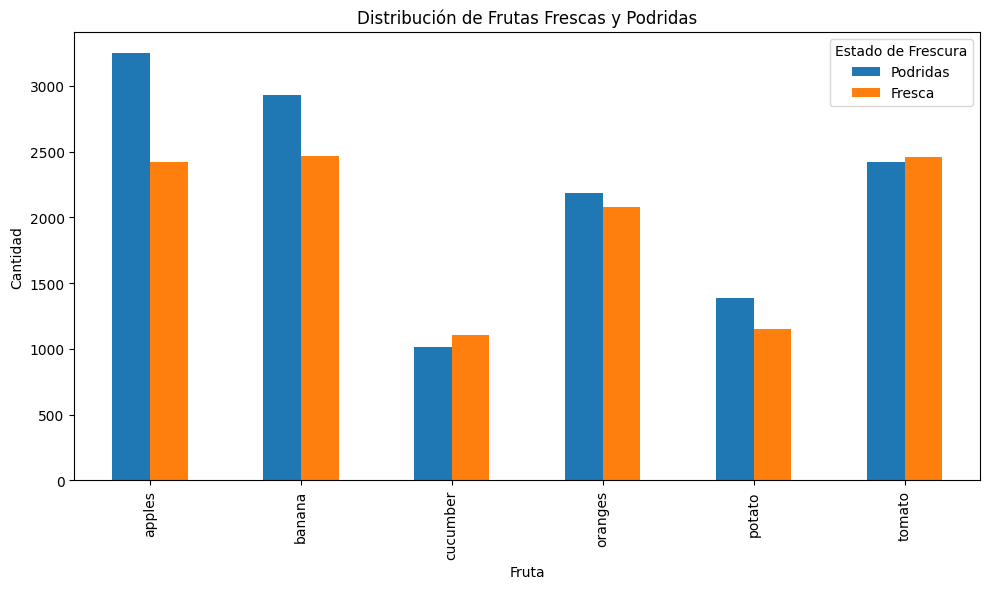

In [19]:
# Funcion definida anteriormente
plot_freshness_distribution(df_train)

Como podemos observar, la cantidad de datos de naranjas, papas y tomates se incrementó considerablemente a comparación de lo que se tenía con un único dataset. Puntualmente, en el dataset anterior, las naranjas y tomates apenas llegaban a 1500 imagenes para rotten & fresh, y ahora estan por encima de las 2000. Algo similar sucede con pepino y papa, las cuales apenas rozaban las 500 imagenes para rotten & fresh, y que ahora han sido practicamente duplicadas en cantidad.

A partir de esto, se decidió no limitar los Dataframes obtenidos ya que de esta manera sería contradictorio con la idea de aumentar el volúmen de datos.

La verdura más limitada en cuanto a cantidad de imágenes es el pepino, pero debido a que es muy distinto en cuanto a forma y color con las otras frutas y verduras analizadas, no lo consideramos como un problema que requiera ser tenido en cuenta.

Una vez obtenidos los Dataframes, se crean los Datasets a partir de ellos, como se hizo anteriormente.

In [20]:
# Crear y configurar los datasets a partir de los dataframes
ds_train, ds_val, ds_test = get_final_datasets(df_train, df_test, BATCH_SIZE=32)

Longitud de ds_train luego de separar: 22382
Longitud de ds_val luego de separar: 2487
Longitud de ds_test: 6144


Vemos que los datasets **aumentaron un 140%** cada uno, respecto a los utilizados antes, pasando de 9229 a 22382 en train, y de 1026 a 2487 en validation.

Por último, se crea el modelo, esta vez sin una capa de data augmentation ya que no es necesaria por la incorporación de las nuevas imágenes de manera manual.

Creemos que esto también puede resultar beneficioso, dado que son imágenes reales y no transformaciones aleatorias aplicadas a imágenes que ya se tienen.

In [21]:
# Parámetros del modelo
input_shape = (IMG_SIZE, IMG_SIZE, 3)  # Tamaño de la imagen de entrada
num_fruits = df_train['fruit'].nunique()  # Número de clases de frutas

model_v2 = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
])

# Creacion de una capa de entrada con las dimensiones correspondientes con las imagenes
inputs = layers.Input(shape=input_shape)

x = model_v2(inputs)

fresh_output = layers.Dense(1, activation='sigmoid', name='fresh_output')(x)

fruit_output = layers.Dense(num_fruits, activation='softmax', name='fruit_output')(x)

# Asociamos las capas de entrada y salida al modelo
model_v2 = tf.keras.Model(inputs=inputs, outputs=[fruit_output, fresh_output])

# Resumen
model_v2.summary()

model_v2.compile(
    optimizer='adam',
    loss={
      'fruit_output': 'sparse_categorical_crossentropy',
      'fresh_output': 'binary_crossentropy'},
    metrics={
      'fruit_output': ["sparse_categorical_accuracy"],
      'fresh_output': ['accuracy']
})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 30976)                19392     ['input_1[0][0]']             
                                                                                                  
 fruit_output (Dense)        (None, 6)                    185862    ['sequential[0][0]']          
                                                                                                  
 fresh_output (Dense)        (None, 1)                    30977     ['sequential[0][0]']          
                                                                                              

Finalmente, entrenamos el modelo con el nuevo conjunto de datos para observar los resultados.

In [22]:
# Entrenar el modelo
history_v2 = model_v2.fit(
    ds_train,
    epochs=5,
    verbose=1,
    validation_data=ds_val,
)

# Evaluar el modelo en el conjunto de test
loss, fruit_loss, fresh_loss, fruit_acc, fresh_acc = model_v2.evaluate(ds_test)

evaluate_v2 = {
    'loss': loss,
    'fruit_loss': fruit_loss,
    'fresh_loss': fresh_loss,
    'fruit_acc': fruit_acc,
    'fresh_acc': fresh_acc
}

print(f"Fruit Accuracy: {evaluate_v2['fruit_acc']}, Fresh Accuracy: {evaluate_v2['fresh_acc']}")
tf.keras.backend.clear_session()

Epoch 1/5
700/700 [==============================] - 137s 98ms/step - loss: 0.8841 - fruit_output_loss: 0.4544 - fresh_output_loss: 0.4296 - fruit_output_sparse_categorical_accuracy: 0.8356 - fresh_output_accuracy: 0.7918 - val_loss: 0.5968 - val_fruit_output_loss: 0.2327 - val_fresh_output_loss: 0.3642 - val_fruit_output_sparse_categorical_accuracy: 0.9176 - val_fresh_output_accuracy: 0.8380
Epoch 2/5
700/700 [==============================] - 122s 97ms/step - loss: 0.4887 - fruit_output_loss: 0.1910 - fresh_output_loss: 0.2977 - fruit_output_sparse_categorical_accuracy: 0.9344 - fresh_output_accuracy: 0.8703 - val_loss: 0.4585 - val_fruit_output_loss: 0.1697 - val_fresh_output_loss: 0.2888 - val_fruit_output_sparse_categorical_accuracy: 0.9393 - val_fresh_output_accuracy: 0.8770
Epoch 3/5
700/700 [==============================] - 127s 98ms/step - loss: 0.3618 - fruit_output_loss: 0.1185 - fresh_output_loss: 0.2432 - fruit_output_sparse_categorical_accuracy: 0.9601 - fresh_output_acc

## Analisis de Resultados - Modelo v2
En este segundo modelo hemos podido demostrar la hipótesis descripta anteriormente, donde presuponiamos que datasets con mayor cantidad de imágenes, y no deformadas por capas de augmentation, podrían arrojar mejores resultados.
Esta configuración donde solo hemos quitado el data augmentation e incluído nuevas imágenes, ha logrado una precisión que ronda el 98% para reconocimiento de fruta y 94% para detección de frescura.



## Estadísticas - Modelo v2

Luego de probar el nuevo modelo, se pueden generar gráficos para evaluando las medidas obtenidas, comparando la precisión y pérdida de entrenamiento contra la validación para ambas salidas.

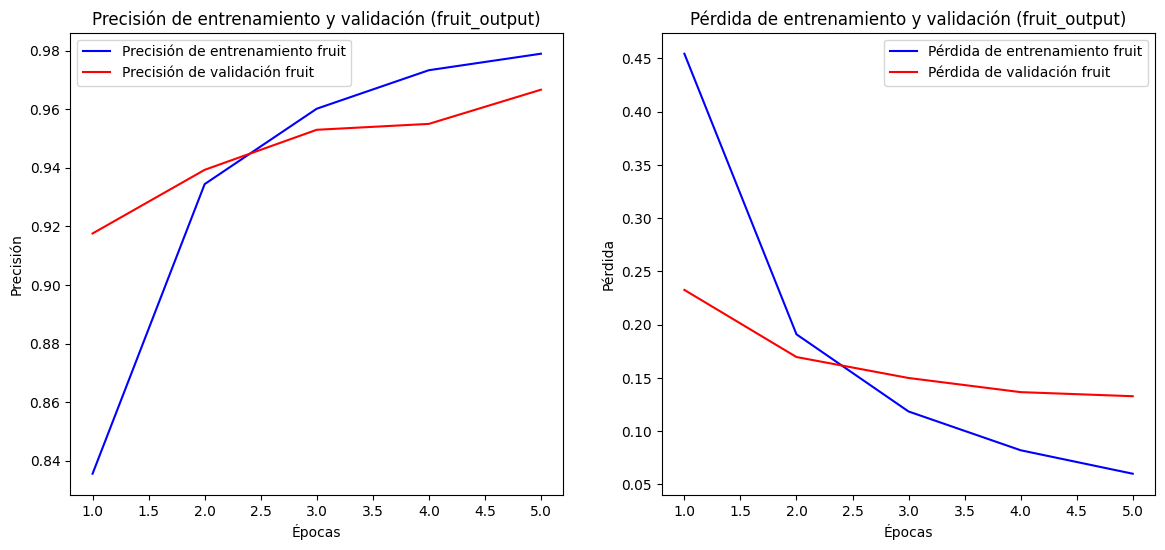

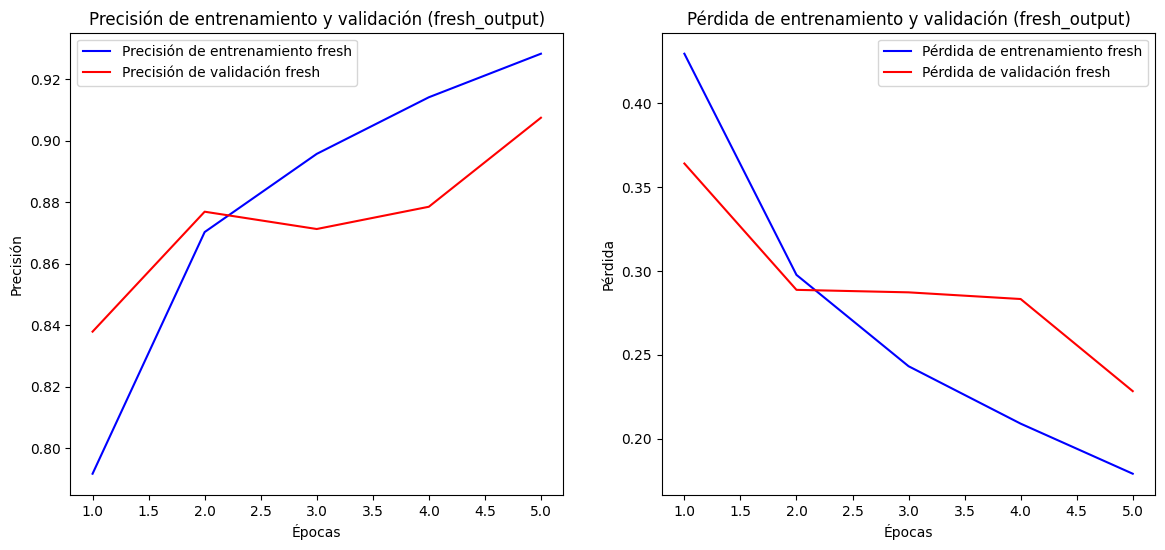

In [23]:
def obtener_metricas(history):
    metricas = {
        'acc': history.history['fruit_output_sparse_categorical_accuracy'],
        'val_acc': history.history['val_fruit_output_sparse_categorical_accuracy'],
        'loss': history.history['fruit_output_loss'],
        'val_loss': history.history['val_fruit_output_loss'],
        'fresh_acc': history.history['fresh_output_accuracy'],
        'val_fresh_acc': history.history['val_fresh_output_accuracy'],
        'fresh_loss': history.history['fresh_output_loss'],
        'val_fresh_loss': history.history['val_fresh_output_loss'],
        'epochs': range(1, len(history.history['fruit_output_sparse_categorical_accuracy']) + 1)
    }
    return metricas

def graficar_metricas(epochs, train_metric, val_metric, train_label, val_label, title, xlabel, ylabel):
    plt.plot(epochs, train_metric, 'b', label=train_label)
    plt.plot(epochs, val_metric, 'r', label=val_label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

def graficar_resultados(metricas):
    epochs = metricas['epochs']

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    graficar_metricas(epochs, metricas['acc'], metricas['val_acc'],
        'Precisión de entrenamiento fruit',
        'Precisión de validación fruit',
        'Precisión de entrenamiento y validación (fruit_output)',
        'Épocas',
        'Precisión'
    )

    # Graficar la pérdida para fruit_output
    plt.subplot(1, 2, 2)
    graficar_metricas(epochs, metricas['loss'], metricas['val_loss'],
        'Pérdida de entrenamiento fruit',
        'Pérdida de validación fruit',
        'Pérdida de entrenamiento y validación (fruit_output)',
        'Épocas',
        'Pérdida'
    )

    plt.show()

    # Graficar la precisión para fresh_output
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    graficar_metricas(epochs, metricas['fresh_acc'], metricas['val_fresh_acc'],
        'Precisión de entrenamiento fresh',
        'Precisión de validación fresh',
        'Precisión de entrenamiento y validación (fresh_output)',
        'Épocas',
        'Precisión'
    )

    # Graficar la pérdida para fresh_output
    plt.subplot(1, 2, 2)
    graficar_metricas(epochs, metricas['fresh_loss'], metricas['val_fresh_loss'],
        'Pérdida de entrenamiento fresh',
        'Pérdida de validación fresh',
        'Pérdida de entrenamiento y validación (fresh_output)',
        'Épocas',
        'Pérdida'
    )

    plt.show()

# Uso de las funciones

metricas = obtener_metricas(history_v2)
graficar_resultados(metricas)


## Análisis del historial de entrenamiento

En base a los gráficos mostrados, podemos evidenciar una diferencia entre los valores de validation y train en cualquiera de los casos (sea para loss o accuracy), donde train obtiene mejores resultados que validation.

Esto denota un leve overfitting en la solución, puesto que el modelo tiene muy buenos numeros para el set de imágenes de entrenamiento, pero no sucede lo mismo con los datos utilizados para validar. Como es de esperar, la diferencia será mayor a medida que avanzan las epochs, pues el modelo se irá ajustando aún más a los datos de entrenamiento, perdiendo así generalidad en el modo de clasificación

Mas allá de haber obtenido un porcentaje de precisión alto, no resulta suficiente para elaborar un análisis completo, pues debemos probar con distintas configuraciones de redes utilizando estos mismos datos, y entonces concluir si se puede lograr una precisión aún mayor o no. Por ello realizamos nuevas modificaciones, que son descriptas a continuación


# Configuración Modelo v3

En este nuevo modelo, agregamos una capa convolucional de 32 filtros de 3x3, y cambiamos el optimizador Adam por SGD.

In [24]:
# Parámetros del modelo
input_shape = (IMG_SIZE, IMG_SIZE, 3)  # Tamaño de la imagen de entrada
num_fruits = df_train['fruit'].nunique()  # Número de clases de frutas

model_v3 = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 5, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
])

# Creacion de una capa de entrada con las dimensiones correspondientes con las imagenes
inputs = layers.Input(shape=input_shape)

x = model_v3(inputs)

fresh_output = layers.Dense(1, activation='sigmoid', name='fresh_output')(x)

fruit_output = layers.Dense(num_fruits, activation='softmax', name='fruit_output')(x)

# Asociamos las capas de entrada y salida al modelo
model_v3 = tf.keras.Model(inputs=inputs, outputs=[fruit_output, fresh_output])

# Resumen
model_v3.summary()

model_v3.compile(
    optimizer='sgd',
    loss={
      'fruit_output': 'sparse_categorical_crossentropy',
      'fresh_output': 'binary_crossentropy'},
    metrics={
      'fruit_output': ['sparse_categorical_accuracy'],
      'fresh_output': ['accuracy']
})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 5184)                 61408     ['input_1[0][0]']             
                                                                                                  
 fruit_output (Dense)        (None, 6)                    31110     ['sequential[0][0]']          
                                                                                                  
 fresh_output (Dense)        (None, 1)                    5185      ['sequential[0][0]']          
                                                                                              

In [25]:
# Entrenar el modelo
history_v3 = model_v3.fit(
    ds_train,
    epochs=5,
    verbose=1,
    validation_data=ds_val,
)

# Evaluar el modelo en el conjunto de test
loss, fruit_loss, fresh_loss, fruit_acc, fresh_acc = model_v3.evaluate(ds_test)

evaluate_v3 = {
    'loss': loss,
    'fruit_loss': fruit_loss,
    'fresh_loss': fresh_loss,
    'fruit_acc': fruit_acc,
    'fresh_acc': fresh_acc
}

print(f"Fruit Accuracy: {evaluate_v3['fruit_acc']}, Fresh Accuracy: {evaluate_v3['fresh_acc']}")
tf.keras.backend.clear_session()

Epoch 1/5
700/700 [==============================] - 148s 127ms/step - loss: 1.6281 - fruit_output_loss: 1.0192 - fresh_output_loss: 0.6089 - fruit_output_sparse_categorical_accuracy: 0.6178 - fresh_output_accuracy: 0.6590 - val_loss: 1.1562 - val_fruit_output_loss: 0.6467 - val_fresh_output_loss: 0.5095 - val_fruit_output_sparse_categorical_accuracy: 0.7740 - val_fresh_output_accuracy: 0.7583
Epoch 2/5
700/700 [==============================] - 121s 93ms/step - loss: 0.9906 - fruit_output_loss: 0.5232 - fresh_output_loss: 0.4674 - fruit_output_sparse_categorical_accuracy: 0.8227 - fresh_output_accuracy: 0.7762 - val_loss: 0.7735 - val_fruit_output_loss: 0.3644 - val_fresh_output_loss: 0.4091 - val_fruit_output_sparse_categorical_accuracy: 0.8862 - val_fresh_output_accuracy: 0.8090
Epoch 3/5
700/700 [==============================] - 125s 100ms/step - loss: 0.7870 - fruit_output_loss: 0.3781 - fresh_output_loss: 0.4088 - fruit_output_sparse_categorical_accuracy: 0.8741 - fresh_output_a

## Análisis de resultados - Modelo v3
Luego del entrenamiento y test, obtuvimos una precisión para clasificación de fruta y frescura de aproximadamente un 94% y 90% respectivamente.

A comparación del modelo anterior, **estamos un 4% debajo** en cuanto a precisión, lo cual nos indica que *agregar más capas de convolución y cambiar el optimizador no deriva en una mejor performance de la red*. Entendemos que cada capa de convolución y pooling puede incrementar la complejidad del modelo, pero no necesariamente mejora la precisión si no se dispone de suficientes datos de entrenamiento. Además, cambiar el optimizador puede afectar la convergencia del modelo.



# Configuración Modelo v4
Por último, y en base a lo evaluado, vamos a probar una última red que utilice un dataset con imágenes más grandes, y una pequeña primer capa de convolución. En teoría, utilizar imágenes con más detalle podría brindarle más información al modelo, y quizás mejorar la precisión.

In [26]:
# Recreamos los datasets con nuevo tamaño de imagen y batch
IMG_SIZE = 160 # Para mayor detalle
ds_train, ds_val, ds_test = get_final_datasets(df_train, df_test, BATCH_SIZE=8) # Batch_size reducido para evitar sobrecarga de RAM

# Verificar el tamaño de los datasets
print("Longitud de ds_train luego de separar:", len(ds_train))
print("Longitud de ds_val luego de separar:", len(ds_val))
print("Longitud de ds_test:", len(ds_test))

input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_fruits = df_train['fruit'].nunique()

model_v4 = tf.keras.Sequential([
    layers.Conv2D(16, 4, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 5, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
])

# Creacion de una capa de entrada con las dimensiones correspondientes con las imagenes
inputs = layers.Input(shape=input_shape)

x = model_v4(inputs)

fresh_output = layers.Dense(1, activation='sigmoid', name='fresh_output')(x)

fruit_output = layers.Dense(num_fruits, activation='softmax', name='fruit_output')(x)

# Asociamos las capas de entrada y salida al modelo
model_v4 = tf.keras.Model(inputs=inputs, outputs=[fruit_output, fresh_output])

# Resumen
model_v4.summary()

model_v4.compile(
    optimizer='adam',
    loss={
      'fruit_output': 'sparse_categorical_crossentropy',
      'fresh_output': 'binary_crossentropy'},
    metrics={
      'fruit_output': ['sparse_categorical_accuracy'],
      'fresh_output': ['accuracy']
})

Longitud de ds_train luego de separar: 22382
Longitud de ds_val luego de separar: 2487
Longitud de ds_test: 6144
Longitud de ds_train luego de separar: 2798
Longitud de ds_val luego de separar: 311
Longitud de ds_test: 768
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 18496)                56688     ['input_1[0][0]']             
                                                                                                  
 fruit_output (Dense)        (None, 6)                    110982    ['sequential[0][0]']          
                                                                     

In [27]:
# Entrenar el modelo
history_v4 = model_v4.fit(
    ds_train,
    epochs=5,
    verbose=1,
    validation_data=ds_val,
)

# Evaluar el modelo en el conjunto de test
loss, fruit_loss, fresh_loss, fruit_acc, fresh_acc = model_v4.evaluate(ds_test)

evaluate_v4 = {
    'loss': loss,
    'fruit_loss': fruit_loss,
    'fresh_loss': fresh_loss,
    'fruit_acc': fruit_acc,
    'fresh_acc': fresh_acc
}

print(f"Fruit Accuracy: {evaluate_v4['fruit_acc']}, Fresh Accuracy: {evaluate_v4['fresh_acc']}")
tf.keras.backend.clear_session()

Epoch 1/5
2798/2798 [==============================] - 151s 45ms/step - loss: 0.8481 - fruit_output_loss: 0.4315 - fresh_output_loss: 0.4166 - fruit_output_sparse_categorical_accuracy: 0.8464 - fresh_output_accuracy: 0.8040 - val_loss: 0.5249 - val_fruit_output_loss: 0.2122 - val_fresh_output_loss: 0.3127 - val_fruit_output_sparse_categorical_accuracy: 0.9244 - val_fresh_output_accuracy: 0.8629
Epoch 2/5
2798/2798 [==============================] - 143s 44ms/step - loss: 0.4581 - fruit_output_loss: 0.1867 - fresh_output_loss: 0.2714 - fruit_output_sparse_categorical_accuracy: 0.9393 - fresh_output_accuracy: 0.8871 - val_loss: 0.4757 - val_fruit_output_loss: 0.1866 - val_fresh_output_loss: 0.2891 - val_fruit_output_sparse_categorical_accuracy: 0.9401 - val_fresh_output_accuracy: 0.8774
Epoch 3/5
2798/2798 [==============================] - 165s 51ms/step - loss: 0.3322 - fruit_output_loss: 0.1198 - fresh_output_loss: 0.2124 - fruit_output_sparse_categorical_accuracy: 0.9612 - fresh_outp

## Análisis de Resultados - Modelo v4

Finalmente, luego de agregar una nueva capa de convolución y agrandar el tamaño de las imágenes, no pudimos incrementar la precisión de la red neuronal mas allá del 98% obtenido en el modelo v2. En tanto, podemos decir que hemos encontrado un óptimo en la configuración de la red, donde a pesar de las variaciones, no logramos mayor efectividad. Esto supone que, llegado cierto punto, la precisión de la red depende principalmente de los datos proporcionados, tanto en cantidad como en calidad.

En los siguientes apartados realizaremos análisis principalmente gráficos para poder observar más claramente el rendimiento de las distintas variantes.


# Comparativas de rendimiento en cada modelo


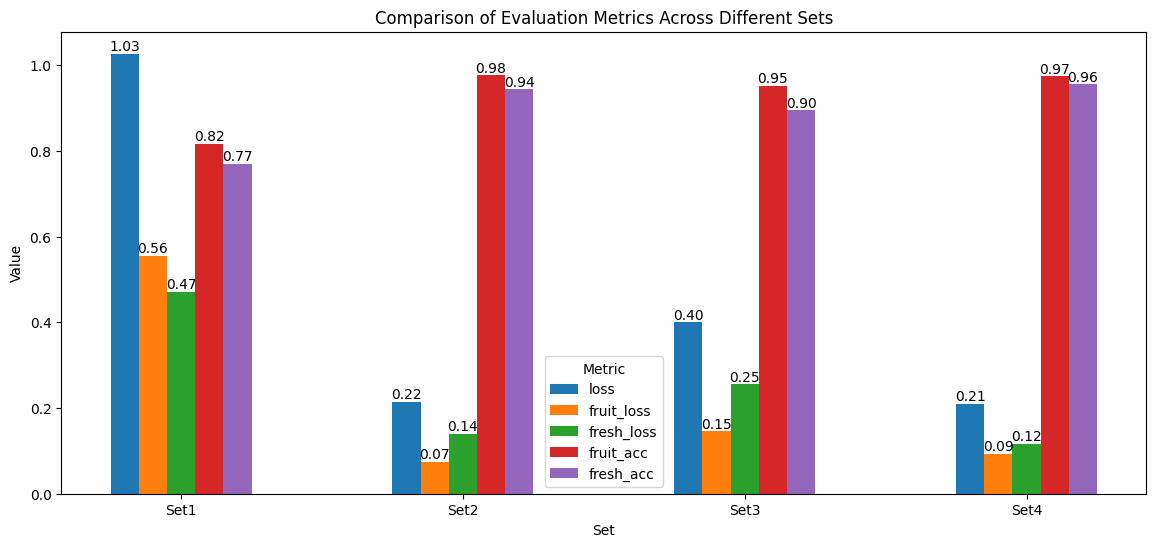

In [34]:
# Métricas
metrics = evaluate_v1.keys()

# Valores por conjunto
set1_values = [evaluate_v1[metric] for metric in metrics]
set2_values = [evaluate_v2[metric] for metric in metrics]
set3_values = [evaluate_v3[metric] for metric in metrics]
set4_values = [evaluate_v4[metric] for metric in metrics]

# Datos en listas
all_values = [set1_values, set2_values, set3_values, set4_values]
labels = ['Set1', 'Set2', 'Set3', 'Set4']

import matplotlib.pyplot as plt
import numpy as np

# Configuración del gráfico
bar_width = 0.1
index = np.arange(len(labels))

# Crear el gráfico
fig, ax = plt.subplots(figsize=(14, 6))

# Añadir barras para cada métrica
for i, metric in enumerate(metrics):
    values = [set[i] for set in all_values]
    bars = ax.bar(index + i * bar_width, values, bar_width, label=metric)

    # Añadir valores encima de cada barra
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')


# Configuración de etiquetas y título
ax.set_xlabel('Set')
ax.set_ylabel('Value')
ax.set_title('Comparison of Evaluation Metrics Across Different Sets')
ax.set_xticks(index + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(labels)
ax.legend(title='Metric')

# Mostrar el gráfico
plt.show()

A partir de la comparativa de los **rendimientos obtenidos utilizando el dataset de prueba**, podemos observar que:

1. Todos los modelos que utilizaron el dataset extendido (v2, v3 y v4) se han **comportado de manera similar a pesar de las variaciones en la configuración de la red.**
2. El **Modelo v1** (con dataset acotado) tuvo una gran tasa de pérdida, tanto general como en cada salida de la red. Esto indica que **el modelo no está clasificando adecuadamente en gran parte de los casos y, en consecuencia, tampoco ajusta bien los pesos en la red neuronal.** Esto también se ve reflejado en el porcentaje de aciertos.
3. A partir de lo mencionado en el punto 1 y 2, podemos concluir que **el dataset es quien termina marcando más la diferencia en términos de precisión del modelo**, dejando en un segundo plano la configuración de la red y otras variables.




# Predicción a partir de una imágen - Modelo v2

Con el objetivo de permitir verificar predicciones personalizadas fuera del conjunto de datos original, se agregó la capacidad de predecir la fruta o verdura junto con su nivel de frescura a partir de imágenes cargadas de manera independiente a los datos de entrenamiento o de prueba.

Esto demuestra la utilidad del modelo en aplicaciones del mundo real, además de mejorar la comprensión del modelo más allá de los datos de entrenamiento y prueba predefinidos, proporcionando una evaluación de la confianza del modelo en sus predicciones.

Es necesario aclarar que, dado que el output fresh varia entre 0 y 1, donde 1 es Fresh y 0 Rotten, un valor cercano a 0.5 indica indecision en el resultado, mientras que los extremos indican seguridad. Para representar esta indecisión, se agregó la medida `freshness reliability`, que expresa la confianza en el resultado de frescura. En tanto, una frescura cercana al 0.5 daría un freshness_reliability cercano a 0%, mientras que los extremos se acercarían al 100%

Para realizar las pruebas en esta sección, decidimos utilizar el modelo v2. Sin embargo, se podrían haber utilizado tanto el modelo v3 como el v4, puesto que todos ellos presentan resultados similares.

## Requisitos para ejecutar

Antes de empezar, es necesario realizar una serie de pasos para incluir en el entorno la carpeta con imagenes de prueba:
1. Les hemos compartido la carpeta `Neuroscience`, con lo cual deberían poder acceder a ella a través del mail de notificación *(enviado a neuroai_lab@alumnos.exa.unicen.edu.ar)*
2. Una vez en la carpeta:
  1. Clickear en el nombre. Se desplegará un panel de opciones
  2. Elegir la opción `Organizar` y luego `Añadir acceso directo`
  3. En el panel, seleccionar: `Todas las ubicaciones`
  4. Al pasar el mouse por `Mi Unidad` aparece la opción `Añadir`. Clickear allí
3. Una vez hecho esto, la carpeta necesaria para esta sección debería aparecer en `/content/drive/MyDrive/Neuroscience/test_model_predict` en el panel lateral izquierdo de este entorno

In [29]:
def predict_image(filepath, category_to_label):
    # Cargar y preprocesar la imagen
    img = image.load_img(filepath, target_size=(96, 96))
    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Hacer predicciones
    predictions = model_v2.predict(img_array)

    # Obtener las predicciones para las dos salidas
    fruit_prediction = predictions[0]
    fresh_prediction = predictions[1]

    # Convertir las predicciones a etiquetas
    predicted_fruit_class = np.argmax(fruit_prediction[0])
    predicted_fruit_label = category_to_label.get(predicted_fruit_class)
    predicted_freshness = 'Fresh' if fresh_prediction[0] > 0.5 else 'Rotten'

    freshnes_reliability = 1 - np.exp(-10 * (fresh_prediction[0][0] - 0.5)**2)

    for i, category in enumerate(category_to_label.values()):
        pctje = fruit_prediction[0][i]*100
        adjusted_pctje = 0 if pctje < 0.01 else pctje
        print(f"{category}: {adjusted_pctje:.2f}%")

    return predicted_fruit_label, predicted_freshness, freshnes_reliability*100


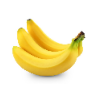

1/1 [==============================] - 0s 29ms/step
apples: 0.00%
banana: 98.99%
cucumber: 0.00%
oranges: 0.05%
potato: 0.95%
tomato: 0.00%
banana-Fresh.jpg
Predicted Fruit: banana
Predicted Freshness: Fresh
Freshness reliability: 91.60%



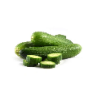

1/1 [==============================] - 0s 49ms/step
apples: 0.00%
banana: 0.00%
cucumber: 100.00%
oranges: 0.00%
potato: 0.00%
tomato: 0.00%
cucumber-Fresh.jpg
Predicted Fruit: cucumber
Predicted Freshness: Fresh
Freshness reliability: 47.26%



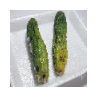

1/1 [==============================] - 0s 33ms/step
apples: 0.00%
banana: 0.00%
cucumber: 99.97%
oranges: 0.00%
potato: 0.00%
tomato: 0.00%
cucumber-Rotten.jpg
Predicted Fruit: cucumber
Predicted Freshness: Rotten
Freshness reliability: 90.90%



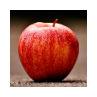

1/1 [==============================] - 0s 32ms/step
apples: 99.76%
banana: 0.00%
cucumber: 0.00%
oranges: 0.00%
potato: 0.00%
tomato: 0.24%
apples-Fresh_2.jpg
Predicted Fruit: apples
Predicted Freshness: Rotten
Freshness reliability: 88.62%



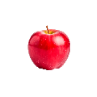

1/1 [==============================] - 0s 37ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.00%
oranges: 0.00%
potato: 0.00%
tomato: 100.00%
apples-Fresh.jpg
Predicted Fruit: tomato
Predicted Freshness: Fresh
Freshness reliability: 91.79%



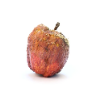

1/1 [==============================] - 0s 33ms/step
apples: 95.25%
banana: 0.00%
cucumber: 0.00%
oranges: 0.14%
potato: 0.40%
tomato: 4.21%
apples-Rotten.jpg
Predicted Fruit: apples
Predicted Freshness: Rotten
Freshness reliability: 90.72%



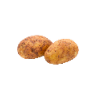

1/1 [==============================] - 0s 33ms/step
apples: 0.12%
banana: 0.59%
cucumber: 0.11%
oranges: 2.47%
potato: 85.51%
tomato: 11.20%
potato-Fresh_2.jpg
Predicted Fruit: potato
Predicted Freshness: Fresh
Freshness reliability: 49.66%



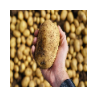

1/1 [==============================] - 0s 32ms/step
apples: 0.00%
banana: 4.18%
cucumber: 0.00%
oranges: 0.00%
potato: 95.77%
tomato: 0.05%
potato-Fresh.jpg
Predicted Fruit: potato
Predicted Freshness: Fresh
Freshness reliability: 6.30%



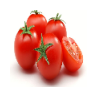

1/1 [==============================] - 0s 28ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.00%
oranges: 0.00%
potato: 0.00%
tomato: 100.00%
tomato-Fresh.jpg
Predicted Fruit: tomato
Predicted Freshness: Fresh
Freshness reliability: 47.69%



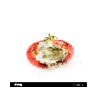

1/1 [==============================] - 0s 31ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.12%
oranges: 0.00%
potato: 38.14%
tomato: 61.74%
tomato-Rotten.jpg
Predicted Fruit: tomato
Predicted Freshness: Rotten
Freshness reliability: 91.66%



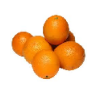

1/1 [==============================] - 0s 25ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.00%
oranges: 100.00%
potato: 0.00%
tomato: 0.00%
oranges-Fresh.jpg
Predicted Fruit: oranges
Predicted Freshness: Fresh
Freshness reliability: 91.55%



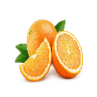

1/1 [==============================] - 0s 27ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.00%
oranges: 99.92%
potato: 0.05%
tomato: 0.03%
oranges-Fresh_2.jpg
Predicted Fruit: oranges
Predicted Freshness: Fresh
Freshness reliability: 91.77%



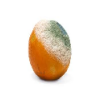

1/1 [==============================] - 0s 29ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.00%
oranges: 99.98%
potato: 0.00%
tomato: 0.01%
oranges-Rotten.jpg
Predicted Fruit: oranges
Predicted Freshness: Rotten
Freshness reliability: 90.55%



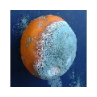

1/1 [==============================] - 0s 28ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.00%
oranges: 97.17%
potato: 2.65%
tomato: 0.18%
oranges-Rotten_2.jpg
Predicted Fruit: oranges
Predicted Freshness: Rotten
Freshness reliability: 89.29%



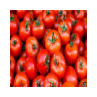

1/1 [==============================] - 0s 27ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.00%
oranges: 0.00%
potato: 0.00%
tomato: 100.00%
tomato-Fresh_2.jpg
Predicted Fruit: tomato
Predicted Freshness: Fresh
Freshness reliability: 90.27%



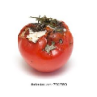

1/1 [==============================] - 0s 39ms/step
apples: 96.26%
banana: 0.00%
cucumber: 0.00%
oranges: 0.00%
potato: 0.00%
tomato: 3.74%
tomato-Rotten_2.jpg
Predicted Fruit: apples
Predicted Freshness: Rotten
Freshness reliability: 90.34%



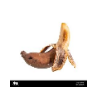

1/1 [==============================] - 0s 35ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.00%
oranges: 0.00%
potato: 100.00%
tomato: 0.00%
banana-Rotten.jpg
Predicted Fruit: potato
Predicted Freshness: Rotten
Freshness reliability: 91.78%



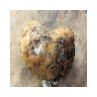

1/1 [==============================] - 0s 27ms/step
apples: 0.00%
banana: 0.27%
cucumber: 0.52%
oranges: 0.03%
potato: 95.16%
tomato: 4.03%
potato-Rotten.jpg
Predicted Fruit: potato
Predicted Freshness: Rotten
Freshness reliability: 91.78%



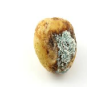

1/1 [==============================] - 0s 33ms/step
apples: 0.00%
banana: 0.00%
cucumber: 0.00%
oranges: 0.17%
potato: 99.82%
tomato: 0.00%
potato-Rotten_2.jpg
Predicted Fruit: potato
Predicted Freshness: Rotten
Freshness reliability: 91.56%



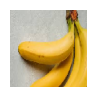

1/1 [==============================] - 0s 33ms/step
apples: 0.01%
banana: 5.35%
cucumber: 1.71%
oranges: 19.73%
potato: 73.19%
tomato: 0.00%
banana-Fresh_2.jpg
Predicted Fruit: potato
Predicted Freshness: Fresh
Freshness reliability: 90.22%



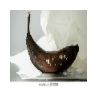

1/1 [==============================] - 0s 26ms/step
apples: 0.00%
banana: 49.88%
cucumber: 12.53%
oranges: 0.00%
potato: 37.44%
tomato: 0.15%
banana-Rotten_2.jpg
Predicted Fruit: banana
Predicted Freshness: Rotten
Freshness reliability: 91.79%



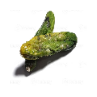

1/1 [==============================] - 0s 32ms/step
apples: 0.00%
banana: 0.00%
cucumber: 100.00%
oranges: 0.00%
potato: 0.00%
tomato: 0.00%
cucumber-Rotten_2.jpg
Predicted Fruit: cucumber
Predicted Freshness: Rotten
Freshness reliability: 91.61%



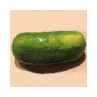

1/1 [==============================] - 0s 26ms/step
apples: 0.00%
banana: 0.00%
cucumber: 100.00%
oranges: 0.00%
potato: 0.00%
tomato: 0.00%
cucumber-Fresh_2.jpg
Predicted Fruit: cucumber
Predicted Freshness: Fresh
Freshness reliability: 84.02%

AVG Freshness reliability: 81.42%


In [44]:
# Test manual con imágenes en Drive
DIR = '/content/drive/MyDrive/Neuroscience/test_model_predict'
category_to_label = dict(enumerate(df_train['fruit'].astype('category').cat.categories))

true_fruits = []
predicted_fruits = []
true_freshness = []
predicted_freshness_array = []
sum_reliability = 0
def extract_class_and_type(image_name):
    # Divide la cadena en la parte antes y después del guion
    parts = image_name.split('-')
    class_name = parts[0]

    # Divide la segunda parte en la parte antes y después del guion bajo
    if '_' in parts[1]:
        type_name = parts[1].split('_')[0]
    else:
        type_name = parts[1].split('.')[0]

    return class_name, type_name

for file in os.listdir(DIR):
    image_path = os.path.join(DIR, file)
    # Extraer las etiquetas reales del nombre del archivo
    true_fruit, true_freshness_value = extract_class_and_type(file)

    predicted_fruit, predicted_freshness, freshnes_reliability = predict_image(image_path, category_to_label)
    sum_reliability += freshnes_reliability
    true_fruits.append(true_fruit)
    predicted_fruits.append(predicted_fruit)
    true_freshness.append(true_freshness_value)
    predicted_freshness_array.append(predicted_freshness)

    print(file)
    print(f'Predicted Fruit: {predicted_fruit}')
    print(f'Predicted Freshness: {predicted_freshness}')
    print(f"Freshness reliability: {freshnes_reliability:.2f}%")
    print()
print(f"AVG Freshness reliability: {sum_reliability/len(os.listdir(DIR)):.2f}%")


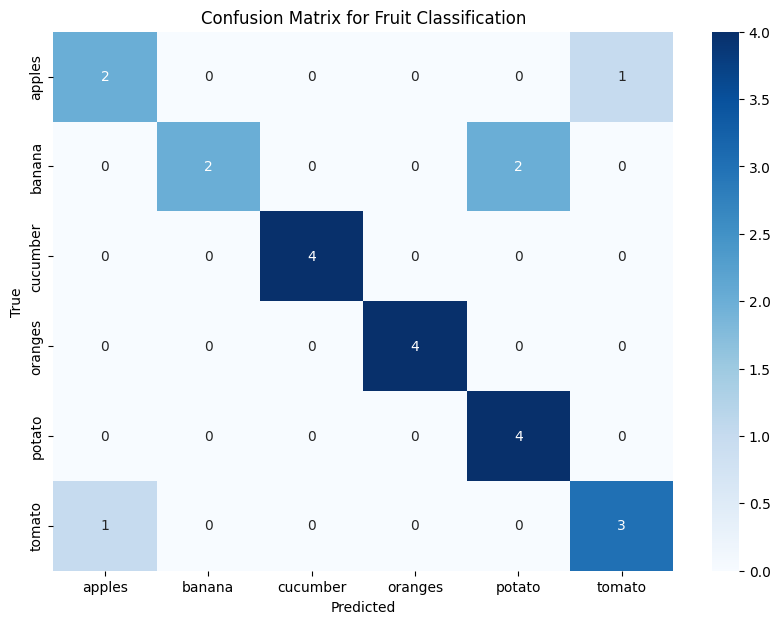

In [45]:
cm = confusion_matrix(true_fruits, predicted_fruits, labels=np.unique(true_fruits))

# Crear el heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_fruits), yticklabels=np.unique(true_fruits))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Fruit Classification')
plt.show()

## Gráfico de Matriz de Confusión para Clasificación de Frutas

La matriz de confusión para la clasificación de frutas muestra cuántas veces se predijo cada fruta correctamente o incorrectamente. Los elementos en la diagonal (desde la esquina superior izquierda hacia la inferior derecha) representan las predicciones correctas, mientras que los elementos fuera de la diagonal  representan las predicciones incorrectas.

Podemos observar que, a pesar de algunos errores, existe una concentración marcada en la diagonal principal, lo cual indica que el modelo tiene una buena precisión en la clasificación de la mayoría de las frutas. Sin embargo, es frecuente que se confunda tomates con manzana, lo cual se puede deber a similitudes visuales entre las mismas.



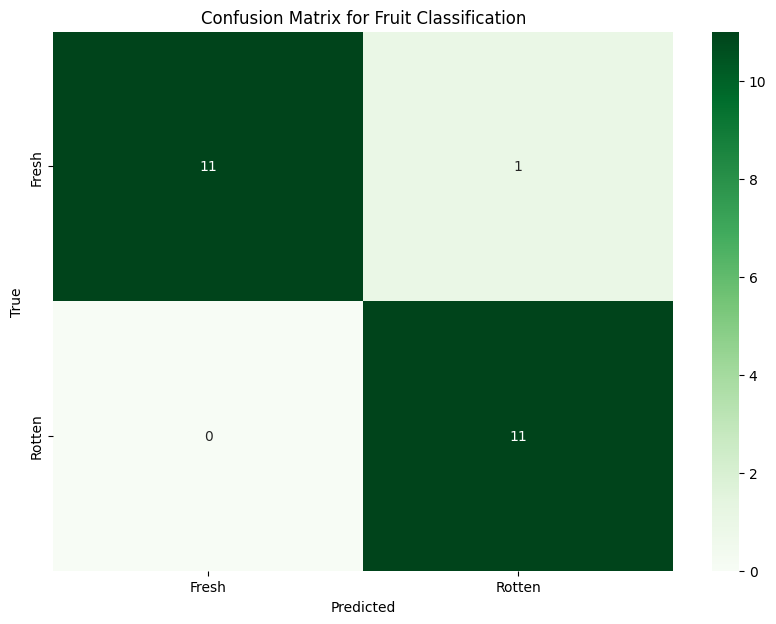

In [46]:
# Gráfico de matriz de confusión para frescura
cm = confusion_matrix(true_freshness, predicted_freshness_array, labels=np.unique(true_freshness))

# Crear el heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(true_freshness), yticklabels=np.unique(true_freshness))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Fruit Classification')
plt.show()


## Gráfico de Matriz de Confusión para Clasificación de Frescura

La matriz de confusión para la clasificación de frescura muestra cuántas veces se predijo correctamente o incorrectamente si una fruta o verdura está fresca o podrida. Al igual que la matriz de frutas, los elementos en la diagonal representan las predicciones correctas.

En este caso se puede notar que la diagonal principal tiene una concentración aún mayor que en el caso de la Clasificación de Frutas, lo cual indica que se confunde menos frecuentemente.  

# Conclusiones

### 1. Impacto de la Limitación de Datos y Data Augmentation
Inicialmente, la limitación de datos seguida de la aplicación de data augmentation no proporcionó los resultados esperados. Este enfoque podría no haber sido efectivo debido a la cantidad insuficiente de datos limitados para capturar la diversidad necesaria en las características de las frutas y verduras. La aplicación de data augmentation sobre un conjunto de datos ya limitado puede no haber generado suficiente variedad en las imágenes, lo que limita la capacidad de la red neuronal para generalizar correctamente.
Además, creemos que la deformación de las imagenes puede derivar en confusiones en el modelo, dado que la forma de una fruta/verdura es importante para su clasificación. Esto se ha podido comprobar viendo el bajo porcentaje de precisión en el modelo que utilizó esta técnica respecto a los demás.

### 2. Importancia de la Cantidad de Datos
La combinación de ambos datasets resultó crucial para mejorar significativamente los resultados de predicción. Esto se vio reflejado en una precisión del 98% en la clasificación de frutas y del 94% en la predicción de frescura. Esto demuestra la importancia crítica de tener un conjunto de datos amplio y diverso para entrenar modelos de aprendizaje automático, especialmente en tareas como la clasificación de objetos y la evaluación de frescura.

### 3. Desafíos en la Predicción
Durante las pruebas, el modelo demostró dificultad para distinguir entre ciertas imágenes, influenciado por la presencia de sombras que afectaron la precisión de las predicciones de frescura. Además, se observaron confusiones entre frutas y verduras que compartían similitudes visuales significativas, como una manzana con un tomate y una papa con una banana. Estas confusiones resaltan la complejidad en la tarea de clasificación visual basada en características sutiles como forma y color.
Consideramos que sería posible evitar estos fallos aumentando aún más los datos de entrenamiento, incluyendo imagenes de frutas/verduras en diferentes condiciones de luz y ambiente puesto que, como se ha visto, los cambios en la cantidad o tipos de capas de neuronas no ha modificado significativamente el resultado del modelo.

### 4. Limitaciones de la Profundización del Modelo
Se observó que, a partir de cierto punto, aumentar el número de epochs o agregar más capas al modelo no produjo variaciones significativas en los porcentajes de precisión obtenidos (98% para la clasificación de frutas y 94% para la predicción de frescura). Esto puede deberse a que el modelo alcanzó su capacidad máxima de aprendizaje con los datos disponibles, y las mejoras adicionales en la arquitectura o en el entrenamiento no aportaron información nueva que pudiera ser aprovechada para mejorar las predicciones. Este fenómeno es conocido como *overfitting*, donde el modelo se ajusta tanto a los datos de entrenamiento que pierde la capacidad de generalizar a datos nuevos.

### 5. Limitaciones del Entorno de Desarrollo
Durante las distintas pruebas y configuraciones de variables, como el batch_size, el img_size, la cantidad de imagenes, la cantidad de capas de convolución, entre otras, nos hemos vistos fuertemente limitados por la memoria RAM del entorno Colab, lo que nos obligó a utilizar cierto de tipo de valores fijos para no exceder los límites de recursos, pero que quizas afectan al rendimiento del modelo entrenado. Consideramos que imágenes más grandes pueden contribuir a mejorar la precisión de la red, debido a la mayor cantidad de detalles que se pueden extraer de ella. Además, mayor cantidad de capas de convolución podrían también favorecer a extraer mayor cantidad de información relevante de cada imagen.